In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import inspect
import gc
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn import metrics

In [4]:
sns.set()

In [6]:
import utils

## Load data

In [195]:
# Load labeled training data
train_df, building, weather_tr = utils.load_data('train', 'data')
train_df = train_df.merge(building, on='building_id', how='left')

Mem. usage decreased to 289.19 Mb (31.8% reduction)
Mem. usage decreased to  0.03 Mb (45.6% reduction)
Mem. usage decreased to  3.07 Mb (43.9% reduction)


In [196]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN
1,1,electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN
2,2,electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN
3,3,electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN
4,4,electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN


In [197]:
# Load unlabeled test data
test_df, building, weather_te = utils.load_data('test', 'data')
test_df = test_df.merge(building, on='building_id', how='left')

Mem. usage decreased to 596.49 Mb (42.3% reduction)
Mem. usage decreased to  0.03 Mb (45.6% reduction)
Mem. usage decreased to  6.08 Mb (43.9% reduction)


In [198]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,electricity,2017-01-01,0,Education,7432,2008.0,NaN
1,1,1,electricity,2017-01-01,0,Education,2720,2004.0,NaN
2,2,2,electricity,2017-01-01,0,Education,5376,1991.0,NaN
3,3,3,electricity,2017-01-01,0,Education,23685,2002.0,NaN
4,4,4,electricity,2017-01-01,0,Education,116607,1975.0,NaN


## Examine training data for accuracy & outliers

In [199]:
# Add log of meter reading
train_df = train_df.assign(meter_reading_log1p = np.log1p(train_df.meter_reading))

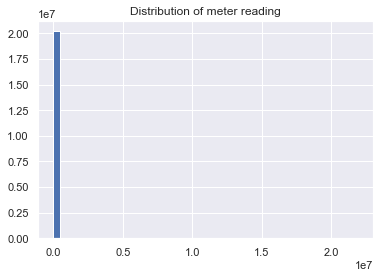

In [200]:
plt.hist(train_df.meter_reading, bins = 50)
plt.title('Distribution of meter reading')
plt.show()

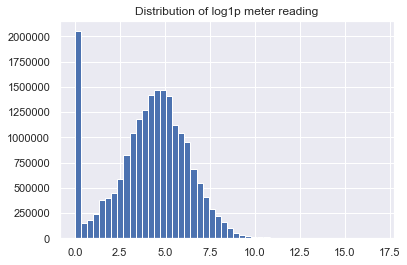

In [201]:
plt.hist(train_df.meter_reading_log1p, bins = 50)
plt.title('Distribution of log1p meter reading')
plt.show()

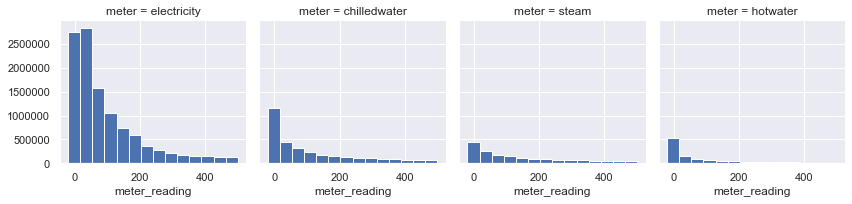

In [202]:
# Plot histogram of meter reading for each meter type
grid = sns.FacetGrid(train_df[['meter', 'meter_reading']], col="meter", margin_titles=True)
grid.map(plt.hist, "meter_reading", bins=np.linspace(-20, 500, 15));

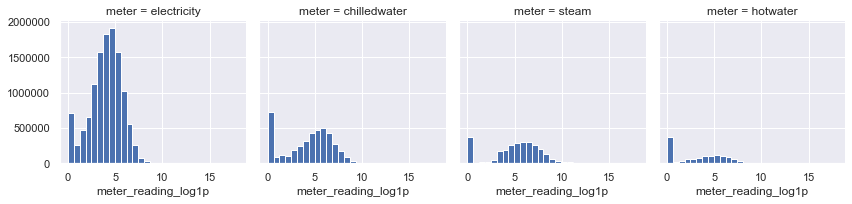

In [203]:
# Plot histogram of LOG meter reading for each meter type
grid = sns.FacetGrid(train_df[['meter', 'meter_reading_log1p']], col="meter", margin_titles=True)
grid.map(plt.hist, "meter_reading_log1p", bins=np.linspace(0, 18, 30));

* `meter_reading` is very heavily right-skewed
* the log1p transformation makes it approximately normal
* in order of number of observations in each meter type: electricity, chilledwater, steam, hotwater

In [204]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

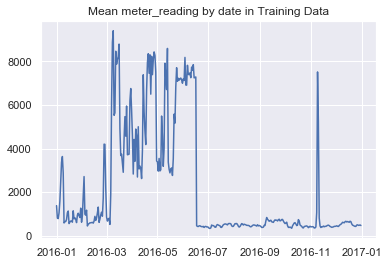

In [205]:
# Average meter reading by day
plt.plot(train_df.assign(dt = lambda df: df.timestamp.dt.date).groupby('dt').agg({'meter_reading': 'mean'}))
plt.title('Mean meter_reading by date in Training Data');

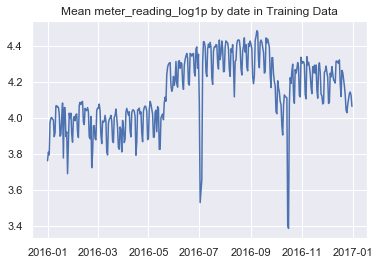

In [206]:
# Average LOG meter reading by day
plt.plot(train_df.assign(dt = lambda df: df.timestamp.dt.date).groupby('dt').agg({'meter_reading_log1p': 'mean'}))
plt.title('Mean meter_reading_log1p by date in Training Data');

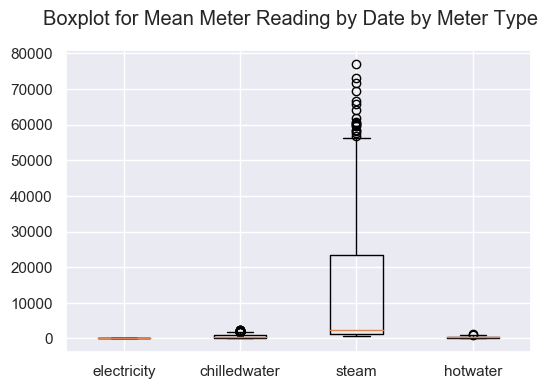

In [207]:
# split by meter type & average by day
plot_data_list = []
for i in ['electricity','chilledwater','steam','hotwater']:
    plot_data = (train_df.loc[train_df['meter'] == i]
                 .assign(dt = lambda df: df.timestamp.dt.date)
                 .groupby(['dt'])
                 .agg({'meter_reading': 'mean'})
                 .reset_index())
    plot_data_list.append(plot_data)
    
# Boxplot by meter type, averaged by day
plot_data_list2 = []
for i in range(4):
    plot_data_list2.append(plot_data_list[i].meter_reading)

# Create subplot
fig, axes = plt.subplots(1,1,figsize=(6, 4), dpi=100)

a0 = axes.boxplot(plot_data_list2)
axes.set_xticklabels(['electricity','chilledwater','steam','hotwater'])
fig.suptitle('Boxplot for Mean Meter Reading by Date by Meter Type');

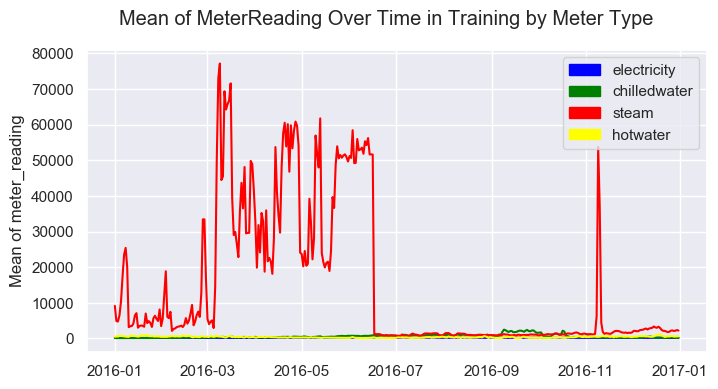

In [208]:
# Plot meter readings by meter type over time
# Create subplot
fig, axes = plt.subplots(1,1,figsize=(8, 4), dpi=100)

# Plot each line over time
a1 = axes.plot(plot_data_list[0].dt, plot_data_list[0].meter_reading, color='blue')
a2 = axes.plot(plot_data_list[1].dt, plot_data_list[1].meter_reading, color='green')
a3 = axes.plot(plot_data_list[2].dt, plot_data_list[2].meter_reading, color='red')
a4 = axes.plot(plot_data_list[3].dt, plot_data_list[3].meter_reading, color='yellow')

axes.set_ylabel('Mean of meter_reading');

# Make legend
blue_patch = mpatches.Patch(color='blue', label='electricity')
green_patch = mpatches.Patch(color='green', label='chilledwater')
red_patch = mpatches.Patch(color='red', label='steam')
yellow_patch = mpatches.Patch(color='yellow', label='hotwater')
plt.legend(handles=[blue_patch, green_patch, red_patch, yellow_patch])

# Add title
fig.suptitle('Mean of MeterReading Over Time in Training by Meter Type');
plt.show()

* plotting mean reading over time does not really make sense, seems to have large outliers in the steam category

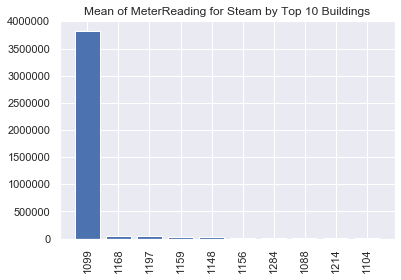

In [209]:
# Investigate steam issues - what building is the issue in?
plot_data = (train_df.loc[train_df['meter'] == 'steam']
             .groupby('building_id').agg({'meter_reading': 'mean'})
             .sort_values('meter_reading', ascending=False)
            .reset_index())
plt.bar(plot_data.index[:10], plot_data.meter_reading.values[:10]);
plt.xticks(plot_data.index[:10], plot_data.building_id[:10], rotation=90);
plt.title('Mean of MeterReading for Steam by Top 10 Buildings');

In [210]:
print('1099 primary use: {}'.format(train_df.loc[train_df['building_id'] == 1099].primary_use.unique().tolist()))
print('1099 meter types: {}'.format(train_df.loc[train_df['building_id'] == 1099].meter.unique().tolist()))

1099 primary use: ['Education']
1099 meter types: ['electricity', 'steam']


In [211]:
# print identifying featuers of 1099 building
building[building['building_id'] == 1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


Max square footage in dataset: 875000


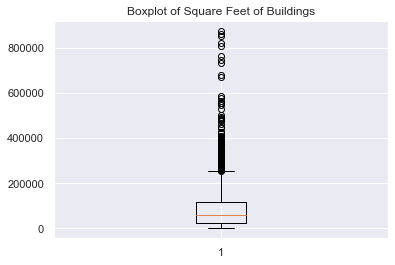

In [212]:
# building_id 1099 has an large sq footage of about 330K, but is by no means the largest
plt.boxplot(building.square_feet)
plt.title('Boxplot of Square Feet of Buildings');
print('Max square footage in dataset: {}'.format(building.square_feet.max()))

In [213]:
print('Median steam reading: {}'.format(train_df.loc[(train_df['meter'] == 'steam')].meter_reading.median()))
print('Median steam reading for building id 1099: {}'.format(train_df.loc[(train_df['building_id'] == 1099) & (train_df['meter'] == 'steam')].meter_reading.mean()))

Median steam reading: 257.81201171875
Median steam reading for building id 1099: 3813981.5


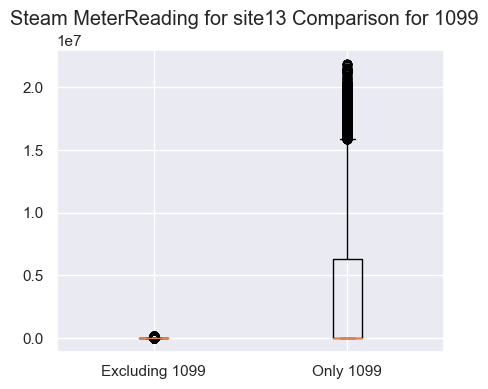

In [214]:
# No other distinguishing features for 1099 other than site_id 13
# Check to see if other buildings at this site have the same issue

# Create subplot
fig, axes = plt.subplots(1,1,figsize=(5, 4), dpi=100)

a = train_df.loc[(train_df['site_id'] == 13) & (train_df['building_id'] != 1099) &
                 (train_df['meter'] == 'steam')].meter_reading
b = train_df.loc[(train_df['site_id'] == 13) & (train_df['building_id'] == 1099) &
                 (train_df['meter'] == 'steam')].meter_reading

a0 = axes.boxplot([a, b])
axes.set_xticklabels(['Excluding 1099', 'Only 1099'])
fig.suptitle('Steam MeterReading for site13 Comparison for 1099');

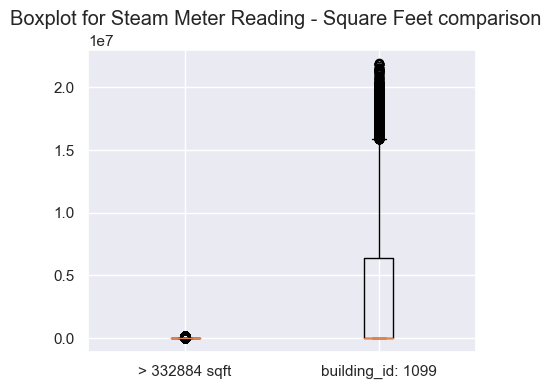

In [215]:
# Check other buildings that have large sq ft - do they also have this amount of skew?
check_building_ids = building[building['square_feet'] > 332884].building_id.values

fig, axes = plt.subplots(1,1,figsize=(5, 4), dpi=100)

a = train_df.loc[(train_df['building_id'].isin(check_building_ids)) & (train_df['meter'] == 'steam'), 'meter_reading']
b = train_df.loc[(train_df['building_id'] == 1099) & (train_df['meter'] == 'steam')].meter_reading

a0 = axes.boxplot([a, b])
axes.set_xticklabels(['> 332884 sqft', 'building_id: 1099'])
fig.suptitle('Boxplot for Steam Meter Reading - Square Feet comparison');

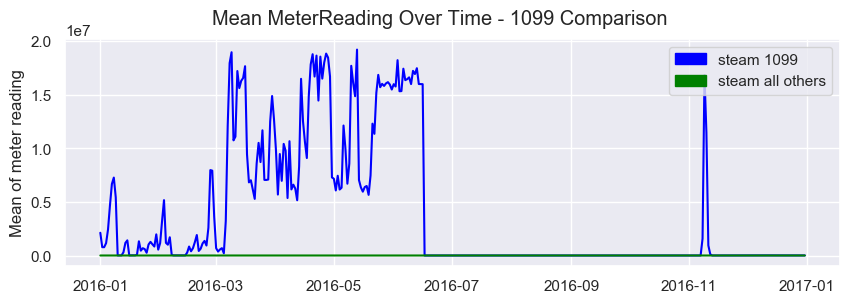

In [216]:
# Plot 1099 over time

a = (train_df.loc[(train_df['meter'] == 'steam') & (train_df['building_id'] == 1099)]
     .assign(dt = lambda df: df.timestamp.dt.date)
     .groupby(['dt'])
     .agg({'meter_reading': 'mean'})
     .reset_index())

b = (train_df.loc[(train_df['meter'] == 'steam') & (~train_df['building_id'].isin([1099]))]
     .assign(dt = lambda df: df.timestamp.dt.date)
     .groupby(['dt'])
     .agg({'meter_reading': 'mean'})
     .reset_index())

# Create subplot
fig, axes = plt.subplots(1,1,figsize=(10, 3), dpi=100)

# Plot each line over time
a1 = axes.plot(a.dt, a.meter_reading, color='blue')
a2 = axes.plot(b.dt, b.meter_reading, color='green')

axes.set_ylabel('Mean of meter reading');

# Make legend
blue_patch = mpatches.Patch(color='blue', label='steam 1099')
green_patch = mpatches.Patch(color='green', label='steam all others')
plt.legend(handles=[blue_patch, green_patch])

# Add title
fig.suptitle('Mean MeterReading Over Time - 1099 Comparison');
plt.show()

* building 1099 is the source of the issues with data seen when plotting `meter_reading` over time
* will remove the steam reading for building 1099 as it seems to be a large outlier
* further investigations into the measurement error of `meter_reading` for other meter types not shown in this notebook, but follows the logic here

**Summary of meter reading issues found to be removed from training:**
   * `building_id = 1099` has issues with the `steam` meter reading - median is 12x median of steam, controlled for sqft
   * `building_id = 1197` has issues with the `steam` meter reading - median is 4x median of steam, sqft is at median level
   * `building_id = 778` has issues with the `chillwedwater` meter reading, for 9/8 - 10/19 much higher than average even when sqft is controlled for, 0's in readings outside of that date range
   * `building_id = 1021` has issues with the `hotwater` meter reading much higher than average after controlling for sqft
   * Spotty `meter_reading` coverage for `site_id = 0` before 2/29/16 - most buildings have a record for mean reading but it is 0, with only some buildings having random meterreadings > 0
   * Spotty `meter_reading` coverage for `site_id = 15` from 2/11/16 - 3/28/16 - extremely low meter readings

In [217]:
train_df = utils.tag_training_problems(train_df)

0.17% of meter-reading tagged as problem.


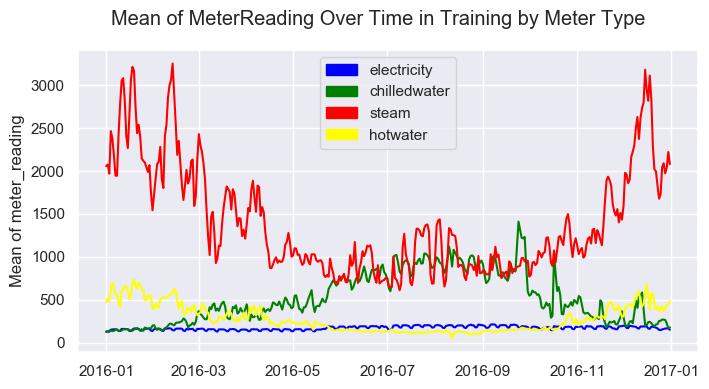

In [218]:
# Re-plot meter readings by meter type over time, this time excluding problem datab
plot_data_list = []
for i in ['electricity','chilledwater','steam','hotwater']:
    plot_data = (train_df.loc[(train_df['meter'] == i) & (train_df['problem_tag'] == 0)]
                 .assign(dt = lambda df: df.timestamp.dt.date)
                 .groupby(['dt'])
                 .agg({'meter_reading': 'mean'})
                 .reset_index())
    plot_data_list.append(plot_data)

# Create subplot
fig, axes = plt.subplots(1,1,figsize=(8, 4), dpi=100)

# Plot each line over time
a1 = axes.plot(plot_data_list[0].dt, plot_data_list[0].meter_reading, color='blue')
a2 = axes.plot(plot_data_list[1].dt, plot_data_list[1].meter_reading, color='green')
a3 = axes.plot(plot_data_list[2].dt, plot_data_list[2].meter_reading, color='red')
a4 = axes.plot(plot_data_list[3].dt, plot_data_list[3].meter_reading, color='yellow')

axes.set_ylabel('Mean of meter_reading');

# Make legend
blue_patch = mpatches.Patch(color='blue', label='electricity')
green_patch = mpatches.Patch(color='green', label='chilledwater')
red_patch = mpatches.Patch(color='red', label='steam')
yellow_patch = mpatches.Patch(color='yellow', label='hotwater')
plt.legend(handles=[blue_patch, green_patch, red_patch, yellow_patch])

# Add title
fig.suptitle('Mean of MeterReading Over Time in Training by Meter Type');
plt.show()

* plotted over time makes a lot more sense now
* can see cyclical trends in energy use, and these trends differ by meter type

## Weather data exploration
* Missing data in weather?
* Are all days for weather filled in?
* lagged variables up to 3 hours are likely to affect current energy consumption
* do all sites have the same count of obs? are there any missing hours that would cause computed lags to be unaligned?

In [219]:
# Check % nulls in weather data frames
weather_tr.isnull().sum() / len(weather_tr) * 100

site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dtype: float64

In [220]:
weather_te.isnull().sum() / len(weather_te) * 100

site_id                0.000000
timestamp              0.000000
air_temperature        0.037512
cloud_coverage        50.658808
dew_temperature        0.117947
precip_depth_1_hr     34.478057
sea_level_pressure     7.670167
wind_direction         4.461790
wind_speed             0.165919
dtype: float64

* `cloud_coverage` & `precip_depth_1_hr` have a big percentage of nulls!

In [221]:
# count of observations by site
weather_tr.groupby('site_id').timestamp.count()

site_id
0     8784
1     8763
2     8783
3     8780
4     8783
5     8755
6     8782
7     8614
8     8784
9     8780
10    8782
11    8614
12    8755
13    8783
14    8777
15    8454
Name: timestamp, dtype: int64

In [222]:
# look at min/max date for each site
print(weather_tr.groupby('site_id').timestamp.min())
print(weather_tr.groupby('site_id').timestamp.max())

site_id
0    2016-01-01 00:00:00
1    2016-01-01 00:00:00
2    2016-01-01 00:00:00
3    2016-01-01 00:00:00
4    2016-01-01 01:00:00
5    2016-01-01 01:00:00
6    2016-01-01 01:00:00
7    2016-01-01 00:00:00
8    2016-01-01 00:00:00
9    2016-01-01 01:00:00
10   2016-01-01 01:00:00
11   2016-01-01 00:00:00
12   2016-01-01 00:00:00
13   2016-01-01 00:00:00
14   2016-01-01 01:00:00
15   2016-01-01 01:00:00
Name: timestamp, dtype: datetime64[ns]
site_id
0    2016-12-31 23:00:00
1    2016-12-31 23:00:00
2    2016-12-31 23:00:00
3    2016-12-31 23:00:00
4    2016-12-31 23:00:00
5    2016-12-31 23:00:00
6    2016-12-31 23:00:00
7    2016-12-31 23:00:00
8    2016-12-31 23:00:00
9    2016-12-31 23:00:00
10   2016-12-31 23:00:00
11   2016-12-31 23:00:00
12   2016-12-31 23:00:00
13   2016-12-31 23:00:00
14   2016-12-31 23:00:00
15   2016-12-31 23:00:00
Name: timestamp, dtype: datetime64[ns]


Steps to forward-fill missing weather data & create lagged variables (in `utils.py`)
1. create all viable hour steps (count of observations by site_id should be equal across all sites)
2. join to weather data, forward-fill all missing data
3. sort by site-id & timestamp
4. calculate 1,2,3 hour lags for weather variables that don't have large % of nulls

In [223]:
weather_tr = utils.ffill_weather(weather_tr)
weather_tr = utils.calculate_lag(weather_tr, 'site_id',
                                 ['air_temperature','dew_temperature','sea_level_pressure',
                                  'wind_direction','wind_speed'], 3)

/Users/sandyliu/anaconda3/lib/python3.7/site-packages/pandas/core/nanops.py:113: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [224]:
weather_te = utils.ffill_weather(weather_te)
weather_te = utils.calculate_lag(weather_te, 'site_id',
                                 ['air_temperature','dew_temperature','sea_level_pressure',
                                  'wind_direction','wind_speed'], 3)

### Weather Timestamp exploration
* Investigate timestamp - we don't know if this is local or not
* Comparing on time segments from an unlocalized timestamp won't be correct
* examine by site_ids, see what hour the highest & lowest temperatures fall on

In [225]:
# Break time into month / day of week / hour of day
weather_tr['timestamp'] = pd.to_datetime(weather_tr['timestamp'])
weather_te['timestamp'] = pd.to_datetime(weather_te['timestamp'])

weather_tr = utils.add_time_segments(weather_tr,'timestamp')
weather_te = utils.add_time_segments(weather_te,'timestamp')

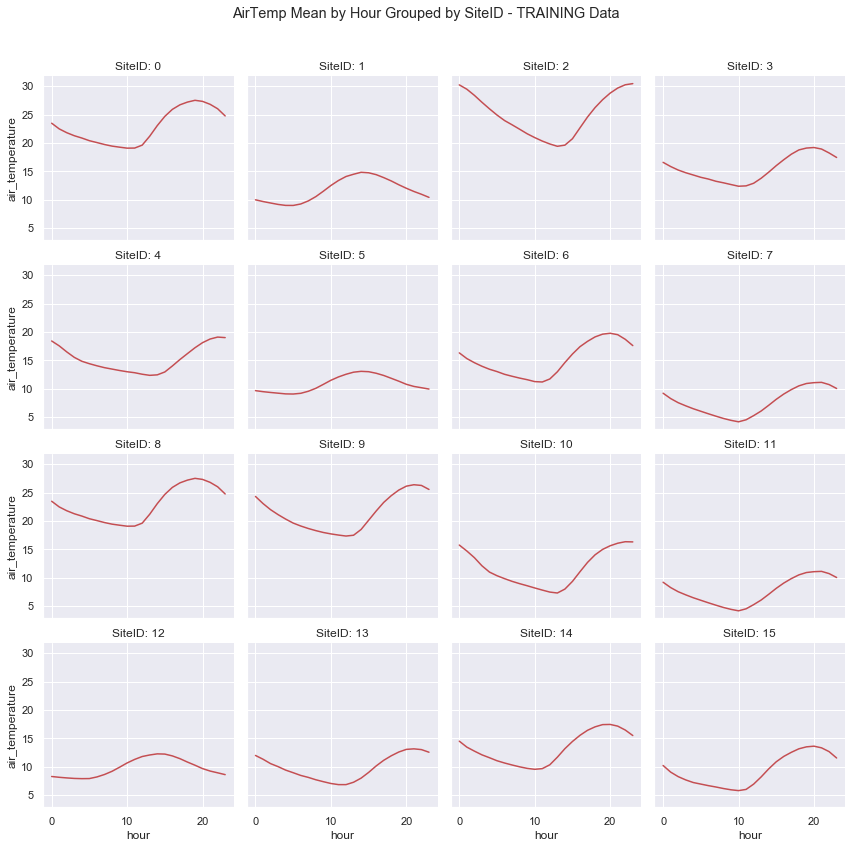

In [226]:
# Plot air temperature by site & hour - where do the peaks fall?
plot_data = weather_tr.groupby(['site_id','hour']).agg({'air_temperature': 'mean'}).reset_index()

plot_data.hour.astype('object')
g = sns.FacetGrid(plot_data, col="site_id", col_wrap=4)
g = (g.map(plt.plot, "hour", "air_temperature", color='r')
     .set_titles("SiteID: {col_name}"));

plt.subplots_adjust(top=0.9)
g.fig.suptitle('AirTemp Mean by Hour Grouped by SiteID - TRAINING Data');

In [227]:
# To align timestamps, calculate the peak average temperature by site, 
# then calculate the offset to add to timestamp,
# based on notion that peak temperature is on average at 2pm
site_max = utils.find_peak_temp(weather_tr)
weather_tr = utils.align_timestamp_local(weather_tr, site_max)
weather_te = utils.align_timestamp_local(weather_te, site_max)

weather_tr = utils.add_time_segments(weather_tr,'timestamp_local')
weather_te = utils.add_time_segments(weather_te,'timestamp_local')

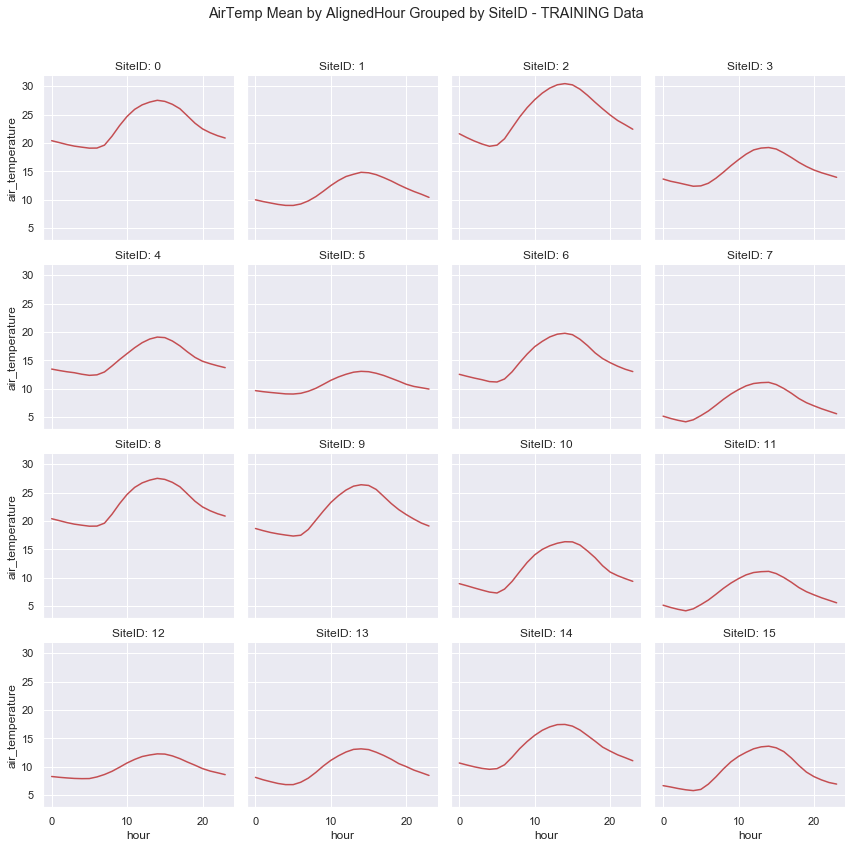

In [228]:
# replot for train data, using aligned timestamp
plot_data = weather_tr.groupby(['site_id','hour']).agg({'air_temperature': 'mean'}).reset_index()

plot_data.hour.astype('object')
g = sns.FacetGrid(plot_data, col="site_id", col_wrap=4)
g = (g.map(plt.plot, "hour", "air_temperature", color='r')
     .set_titles("SiteID: {col_name}"));

plt.subplots_adjust(top=0.9)
g.fig.suptitle('AirTemp Mean by AlignedHour Grouped by SiteID - TRAINING Data');

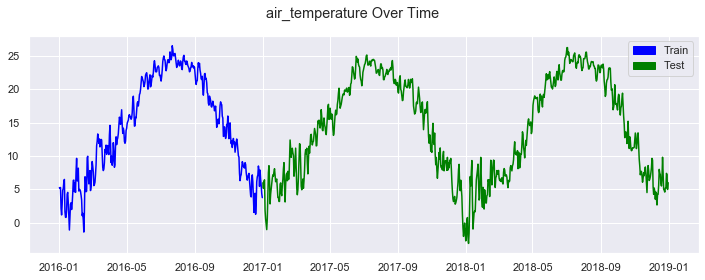

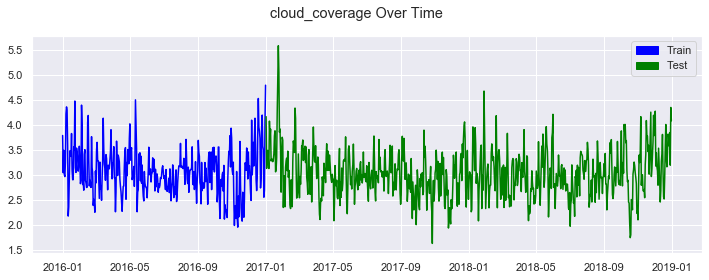

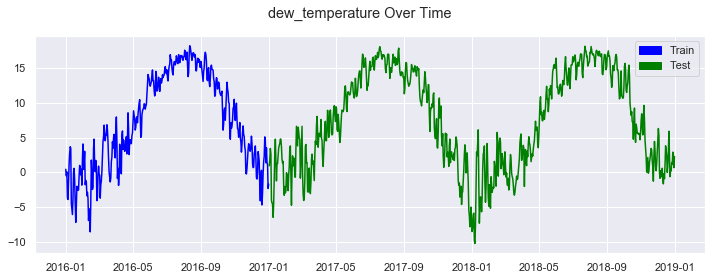

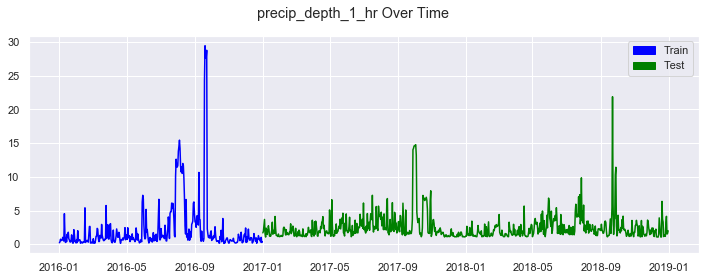

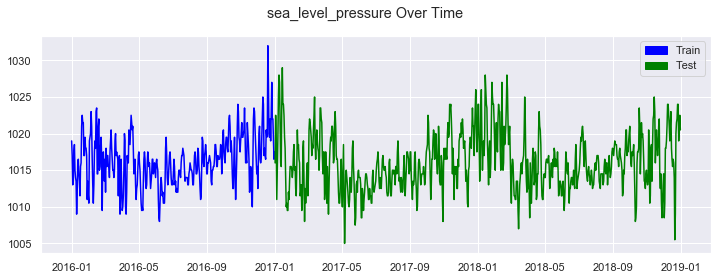

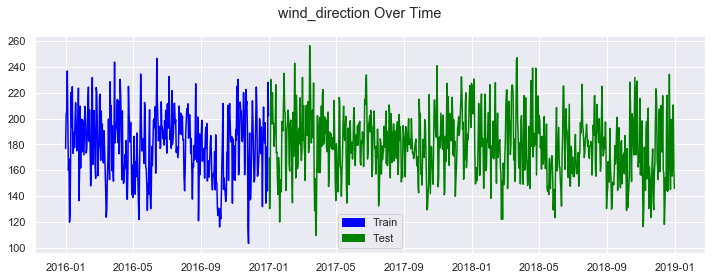

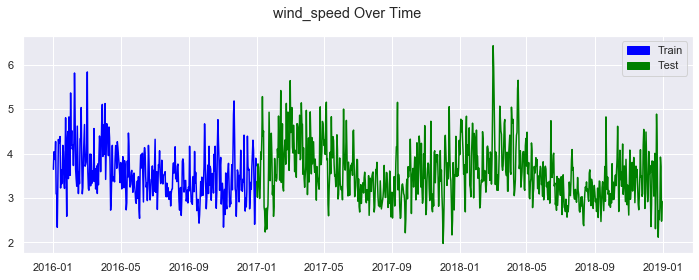

In [229]:
# Plot all weather data over time
for i in ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure',
          'wind_direction','wind_speed']:
    
    a = (weather_tr.assign(dt = lambda df: df.timestamp.dt.date).groupby('dt')
         .agg({i: 'mean'}).reset_index()
         .assign(data = 'train'))

    b = (weather_te.assign(dt = lambda df: df.timestamp.dt.date).groupby('dt')
         .agg({i: 'mean'}).reset_index()
         .assign(dataset = 'test'))

    fig, axes = plt.subplots(1, 1, figsize=(12, 4))

    a1 = axes.plot(a.dt, a[i], color='blue')
    a2 = axes.plot(b.dt, b[i], color='green')

    blue_patch = mpatches.Patch(color='blue', label='Train')
    green_patch = mpatches.Patch(color='green', label='Test')
    plt.legend(handles=[blue_patch, green_patch])

    fig.suptitle('{} Over Time'.format(i));

### Merge weather data

In [234]:
# Merge data with weather data
train_df = train_df.merge(weather_tr, on=['site_id', 'timestamp'], how='left')
test_df = test_df.merge(weather_te, on=['site_id', 'timestamp'], how='left')

In [ ]:
# Free up memory
del weather_tr, weather_te
gc.collect()

* At this point I have cleaned up problem data in `meter_reading`, explored some aspects of weather data and feature-engineered time+weather variables (month, year, dayofweek, lagged weather variables)

## Additional EDA

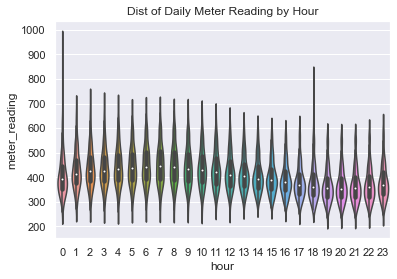

In [237]:
# Graph side-by-side boxplots of target by these time segments - HOUR
plot_data = (train_df.loc[train_df['problem_tag'] == 0]
 .assign(dt = lambda df: df.timestamp.dt.date)
 .groupby(['hour','dt'])
 .agg({'meter_reading': 'mean'})
 .reset_index())

ax = sns.violinplot(x="hour", y="meter_reading", data=plot_data)
ax.set_title('Dist of Daily Meter Reading by Hour');

## Additional Feature Engineering
* Transform or bin variables
* is_holiday 
* is_weekend

## Split data into labeled train/test

In [185]:
# Split by time into train/test
# Set aside test data to estimate true test error!
thresh = round(len(train_df) * 0.8)
ts_thresh = train_df.sort_values('timestamp')['timestamp'].iloc[thresh]

In [186]:
# train/test split
tr = train_df.loc[train_df['timestamp'] < ts_thresh].reset_index().drop(columns='index')
te = train_df.loc[train_df['timestamp'] >= ts_thresh].reset_index().drop(columns='index')

In [187]:
print(tr.shape)
print(te.shape)

(16171648, 38)
(4044452, 38)


In [188]:
print(tr.timestamp.max(), te.timestamp.min())

2016-10-20 18:00:00 2016-10-20 19:00:00


In [189]:
# Clear up memory
del weather_tr, weather_te, building, train_df, plot_data, plot_data_list, plot_data_list2

In [190]:
gc.collect()

50005

In [ ]:
del tr, te
gc.collect()

## Learnings